<a href="https://colab.research.google.com/github/kareem1925/Ismailia-school-of-AI/blob/master/machine%20learning%20for%20classifying%20quantum%20states/pennylane-quantum-state-learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pennylane --upgrade

     |████████████████████████████████| 204kB 2.9MB/s 
  Found existing installation: semantic-version 2.8.4
    Uninstalling semantic-version-2.8.4:
      Successfully uninstalled semantic-version-2.8.4


In [0]:
import os
os.kill(os.getpid(), 9)

In [0]:
import pennylane as qml
from pennylane import numpy as np

In [0]:
dev1 = qml.device('default.qubit',wires=2,analytic=False,shots=1000)

@qml.qnode(dev1)
def circuit(params):
    qml.RY(params[0],wires=0)
    qml.CNOT(wires=[0,1])
    return qml.expval(qml.Hermitian(H,wires=[0,1]))

In [3]:
y = np.array([1/np.sqrt(2),0,0,1/np.sqrt(2)])
H = np.outer(y,y)
print(circuit([np.pi/2]))
dev1.state

0.9999999999999999


array([0.70710678+0.j, 0.        +0.j, 0.        +0.j, 0.70710678+0.j])

In [0]:
def cross_entropy(predictions, targets, epsilon=1e-20):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log10(predictions+epsilon))/N
    return ce

In [0]:
la = np.array([0.5,0,0,0.5])
def cost(var):
#    return cross_entropy(circuit(var),la) if i'm going to use probs value form qnode
    return abs(1 - circuit(var))

In [6]:
np.random.seed(6)
init_params = np.random.rand(1)
print(init_params)
print(cost(init_params))

[0.89286015]
0.10100000000000009


In [7]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

# set the number of steps
steps = 1000
# set the initial parameter values
params = init_params
los = np.inf

cost1000 = []
for i in range(steps):
    # update the circuit parameters
    params = opt.step(cost, params)
    t = cost(params)
    cost1000.append(t)

    if (i + 1) % 1 == 0:
        print("Cost after step {:5d}: {: .30f}".format(i + 1, t))

print("Optimized rotation angles: {}".format(params))
final_1000 = params 

Cost after step     1:  0.107000000000000095035090907913
Cost after step     2:  0.091000000000000080824236192711
Cost after step     3:  0.085000000000000075495165674511
Cost after step     4:  0.083000000000000073718808835110
Cost after step     5:  0.063000000000000166977542903624
Cost after step     6:  0.064000000000000167865721323324
Cost after step     7:  0.056000000000000160760293965723
Cost after step     8:  0.045000000000000150990331349021
Cost after step     9:  0.049000000000000154543045027822
Cost after step    10:  0.051000000000000156319401867222
Cost after step    11:  0.031000000000000138555833473220
Cost after step    12:  0.040000000000000146549439250521
Cost after step    13:  0.031000000000000138555833473220
Cost after step    14:  0.029000000000000136779476633819
Cost after step    15:  0.025000000000000133226762955019
Cost after step    16:  0.026000000000000134114941374719
Cost after step    17:  0.020000000000000128785870856518
Cost after step    18:  0.02300

In [8]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

# set the number of steps
steps = 1000
# set the initial parameter values
params = init_params
dev1.shots = 100

cost100 = []
for i in range(steps):
    # update the circuit parameters
    params = opt.step(cost, params)
    t = cost(params)
    cost100.append(t)

    if (i + 1) % 1 == 0:
        print("Cost after step {:5d}: {: .30f}".format(i + 1, t))

print("Optimized rotation angles: {}".format(params))
final_100 = params

Cost after step     1:  0.090000000000000190958360235527
Cost after step     2:  0.090000000000000190958360235527
Cost after step     3:  0.080000000000000182076576038526
Cost after step     4:  0.060000000000000164313007644523
Cost after step     5:  0.060000000000000164313007644523
Cost after step     6:  0.060000000000000164313007644523
Cost after step     7:  0.040000000000000146549439250521
Cost after step     8:  0.060000000000000164313007644523
Cost after step     9:  0.080000000000000182076576038526
Cost after step    10:  0.050000000000000155431223447522
Cost after step    11:  0.050000000000000155431223447522
Cost after step    12:  0.080000000000000182076576038526
Cost after step    13:  0.030000000000000137667655053519
Cost after step    14:  0.010000000000000119904086659517
Cost after step    15:  0.010000000000000119904086659517
Cost after step    16:  0.020000000000000128785870856518
Cost after step    17:  0.030000000000000137667655053519
Cost after step    18:  0.01000

In [9]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

# set the number of steps
steps = 1000
# set the initial parameter values
params = init_params
dev1.shots = 10

cost10 = []
for i in range(steps):
    # update the circuit parameters
    params = opt.step(cost, params)
    t = cost(params)
    cost10.append(t)

    if (i + 1) % 1 == 0:
        print("Cost after step {:5d}: {: .30f}".format(i + 1, t))

print("Optimized rotation angles: {}".format(params))
final_10 = params

Cost after step     1:  0.300000000000000155431223447522
Cost after step     2:  0.000000000000000222044604925031
Cost after step     3:  0.100000000000000199840144432528
Cost after step     4:  0.000000000000000222044604925031
Cost after step     5:  0.000000000000000222044604925031
Cost after step     6:  0.200000000000000177635683940025
Cost after step     7:  0.000000000000000222044604925031
Cost after step     8:  0.300000000000000155431223447522
Cost after step     9:  0.000000000000000222044604925031
Cost after step    10:  0.000000000000000222044604925031
Cost after step    11:  0.000000000000000222044604925031
Cost after step    12:  0.000000000000000222044604925031
Cost after step    13:  0.000000000000000222044604925031
Cost after step    14:  0.000000000000000222044604925031
Cost after step    15:  0.000000000000000222044604925031
Cost after step    16:  0.000000000000000222044604925031
Cost after step    17:  0.000000000000000222044604925031
Cost after step    18:  0.00000

In [10]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

# set the number of steps
steps = 1000
# set the initial parameter values
params1 = init_params
dev1.shots = 1

cost1 = []
for i in range(steps):
    # update the circuit parameters
    params1 = opt.step(cost, params1)
    t = cost(params1)
    cost1.append(t)

    if (i + 1) % 1 == 0:
        print("Cost after step {:5d}: {: .30f}".format(i + 1, t))

print("Optimized rotation angles: {}".format(params1))
final_1 = params

Cost after step     1:  0.000000000000000222044604925031
Cost after step     2:  0.000000000000000222044604925031
Cost after step     3:  0.000000000000000222044604925031
Cost after step     4:  0.000000000000000222044604925031
Cost after step     5:  0.000000000000000222044604925031
Cost after step     6:  0.000000000000000222044604925031
Cost after step     7:  0.000000000000000222044604925031
Cost after step     8:  0.000000000000000222044604925031
Cost after step     9:  0.000000000000000222044604925031
Cost after step    10:  0.000000000000000222044604925031
Cost after step    11:  0.000000000000000222044604925031
Cost after step    12:  0.000000000000000222044604925031
Cost after step    13:  0.000000000000000222044604925031
Cost after step    14:  0.000000000000000222044604925031
Cost after step    15:  0.000000000000000222044604925031
Cost after step    16:  0.000000000000000222044604925031
Cost after step    17:  1.000000000000000000000000000000
Cost after step    18:  0.00000

In [11]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

# set the number of steps
steps = 1000
# set the initial parameter values
params = init_params
dev1.analytic = True

cost_analytic = []
for i in range(steps):
    # update the circuit parameters
    params = opt.step(cost, params)
    t = cost(params)
    cost_analytic.append(t)

    if (i + 1) % 1 == 0:
        print("Cost after step {:5d}: {: .30f}".format(i + 1, t))

print("Optimized rotation angles: {}".format(params))
final = params

Cost after step     1:  0.100924606840903319238123003743
Cost after step     2:  0.092033140459058193627583932539
Cost after step     3:  0.083848442944459367076603939495
Cost after step     4:  0.076327467421744787934301257337
Cost after step     5:  0.069427476442372237919187227817
Cost after step     6:  0.063106525064910545808061215212
Cost after step     7:  0.057323846787208365682886324066
Cost after step     8:  0.052040152010392137782446297933
Cost after step     9:  0.047217849325630889545379886840
Cost after step    10:  0.042821199972096546382260839891
Cost after step    11:  0.038816415464908105015240380453
Cost after step    12:  0.035171707761533221869854060060
Cost after step    13:  0.031857300528689957985761793680
Cost after step    14:  0.028845409172227332028626278770
Cost after step    15:  0.026110196362872928332876654167
Cost after step    16:  0.023627708876984065966553316684
Cost after step    17:  0.021375800704974690091830780148
Cost after step    18:  0.01933

In [0]:
from matplotlib import pyplot as plt
plt.style.use("fast")

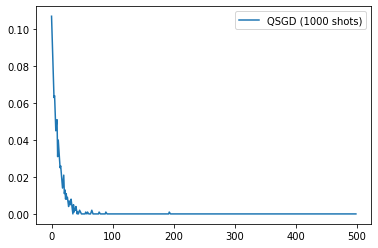

In [15]:
plt.plot(cost1000[:500] ,label="QSGD (1000 shots)")
plt.legend()

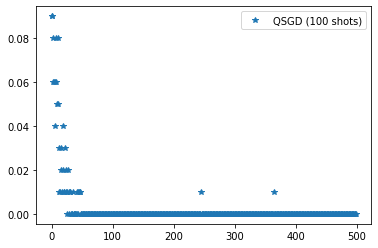

In [16]:
plt.plot(cost100[:500], "*", label="QSGD (100 shots)")
plt.legend()

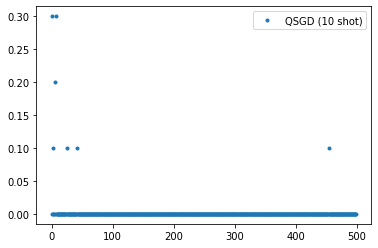

In [17]:
plt.plot(cost10[:500],".", label="QSGD (10 shot)")
plt.legend()

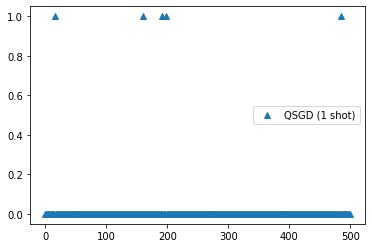

In [18]:
plt.plot(cost1[:500],"^", label="QSGD (1 shot)")
plt.legend()

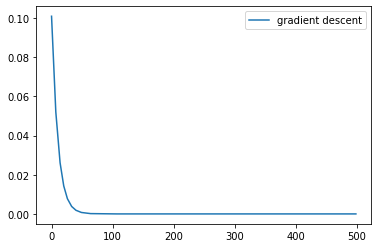

In [21]:
plt.plot(cost_analytic[:500],"-", label="gradient descent")
plt.legend()

In [22]:
print(np.argmin(cost1000),np.argmin(cost100),np.argmin(cost10),np.argmin(cost1),np.argmin(cost_analytic))

35 26 1 0 343


In [23]:
abs(np.dot(dev1.state.conj().T,y))**2

1.0

In [24]:
dev1.state

array([0.70710678+0.j, 0.        +0.j, 0.        +0.j, 0.70710678+0.j])

In [25]:
final,final_1000,final_100,final_10,final_1

(array([1.57079633]),
 array([1.56786015]),
 array([1.57436015]),
 array([1.57286015]),
 array([1.57286015]))